In [1]:
# Cell 1: Environment Setup for Experiment 4
# Purpose: Install libraries for exploratory tunnel peer selection analysis

!pip install paramiko pandas beautifulsoup4 matplotlib -q

import paramiko
import pandas as pd
import re
import sys
from datetime import datetime
from google.colab import userdata
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("EXPERIMENT 4: EXPLORATORY TUNNEL PEER SELECTION ANALYSIS")
print("="*70)
print()
print("Hypothesis: Exploratory tunnels use Standard routers (primary)")
print("            with High Capacity routers as fallback")
print()
print("✅ Environment ready")
print(f"Python: {sys.version.split()[0]} | Paramiko: {paramiko.__version__}")
print("="*70)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.6 MB/s eta 0:00:00
EXPERIMENT 4: EXPLORATORY TUNNEL PEER SELECTION ANALYSIS

Hypothesis: Exploratory tunnels use Standard routers (primary)
            with High Capacity routers as fallback

✅ Environment ready
Python: 3.12.12 | Paramiko: 4.0.0


In [2]:
# Cell 2: SSH Connection to VPS1
# Purpose: Connect to VPS1 and verify I2P is running

from google.colab import userdata

try:
    VPS1_HOST = userdata.get('VPS1_HOST')
    VPS1_USER = userdata.get('VPS1_USERNAME')
    VPS1_PASS = userdata.get('VPS1_PASSWORD')

    print("🔐 Connecting to VPS1...")

    ssh_vps1 = paramiko.SSHClient()
    ssh_vps1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_vps1.connect(hostname=VPS1_HOST, username=VPS1_USER,
                     password=VPS1_PASS, timeout=15)

    print(f"✅ SSH connected: {VPS1_HOST}")

    # Verify I2P
    stdin, stdout, stderr = ssh_vps1.exec_command('pgrep -f i2p')
    if stdout.read():
        print("✅ I2P router is running")

    print()
    print("="*70)
    print("VPS1 CONNECTION: ACTIVE")
    print("="*70)

except Exception as e:
    print(f"❌ Error: {e}")

🔐 Connecting to VPS1...
✅ SSH connected: 107.175.145.4
✅ I2P router is running

VPS1 CONNECTION: ACTIVE


In [3]:
# Cell 3: Extract Peer Profiles - Standard vs High Capacity
# Purpose: Classify all peers for exploratory tunnel context

def extract_and_classify_peers(ssh_client):
    """
    Extract peers and classify for EXPLORATORY tunnel context:
    - High Capacity: Any peer with "High Capacity" label
    - Standard: Everything else (unlabeled, Integrated-only)
    """

    print("📡 Fetching peer profiles from I2P console...")

    cmd = "curl -L -s -m 60 http://127.0.0.1:7657/profiles?f=1 2>/dev/null"
    stdin, stdout, stderr = ssh_client.exec_command(cmd, timeout=65)
    html_content = stdout.read().decode('utf-8', errors='ignore')

    if not html_content or '<table' not in html_content:
        return None

    print(f"✅ Received {len(html_content)} bytes")

    soup = BeautifulSoup(html_content, 'html.parser')
    tables = soup.find_all('table')
    target_table = max(tables, key=lambda t: len(t.find_all('tr')))
    rows = target_table.find_all('tr')

    print(f"📊 Processing {len(rows)-1} peer profiles...")

    peer_data = []

    for row in rows[1:]:
        cells = row.find_all('td')
        if len(cells) < 2:
            continue

        try:
            peer_id = cells[0].get_text(strip=True)
            if not peer_id or len(peer_id) < 3:
                continue

            raw_group = cells[1].get_text(strip=True)

            # CORRECT classification for exploratory tunnels
            if 'High Capacity' in raw_group:
                tier = 'High Capacity'
            else:
                tier = 'Standard'

            peer_data.append({
                'Peer_ID': peer_id,
                'Raw_Group': raw_group[:50],
                'Tier': tier
            })
        except:
            continue

    df = pd.DataFrame(peer_data)

    print(f"\n✅ Extracted {len(df)} peers")
    print("\n📊 TIER DISTRIBUTION:")
    print("="*70)
    for tier, count in df['Tier'].value_counts().items():
        pct = (count / len(df)) * 100
        print(f"  {tier:20s}: {count:5d} ({pct:5.1f}%)")
    print("="*70)

    return df

# Execute
peer_profiles = extract_and_classify_peers(ssh_vps1)

# Show samples
print("\n📋 Sample High Capacity peers:")
print(peer_profiles[peer_profiles['Tier']=='High Capacity'].head(5)[['Peer_ID','Raw_Group']])
print("\n📋 Sample Standard peers:")
print(peer_profiles[peer_profiles['Tier']=='Standard'].head(5)[['Peer_ID','Raw_Group']])

📡 Fetching peer profiles from I2P console...
✅ Received 6228046 bytes
📊 Processing 9987 peer profiles...

✅ Extracted 9985 peers

📊 TIER DISTRIBUTION:
  Standard            :  9835 ( 98.5%)
  High Capacity       :   150 (  1.5%)

📋 Sample High Capacity peers:
  Peer_ID                                          Raw_Group
0    CP07  Fast, High CapacityOR0.9.67179.239.46--OKprofi...
1    DutO  Fast, High Capacity, IntegratedXR0.9.67122.761...
2    FRWZ  Fast, High CapacityXR0.9.67105.5513.36--OKprof...
3    IW07  Fast, High CapacityNR0.9.6688.2811.41--OKprofi...
4    Injh  Fast, High CapacityXR0.9.67117.439.04--OKprofi...

📋 Sample Standard peers:
    Peer_ID                                  Raw_Group
150    ABEc             PR0.9.6449.798.43--OKprofile+-
151    ABL8  IntegratedXfR0.9.67--7.4411.00OKprofile+-
152    ABdc                  PU0.9.67------OKprofile+-
153    ABwG                          ------OKprofile+-
154    AB-T                 PUD0.9.65------OKprofile+-


In [4]:
# Cell 4 FINAL: Extract Exploratory Participants (Experiment 3 Method)
# Purpose: Use proven regex approach from Experiment 3

def extract_exploratory_participants_final(ssh_client):
    """
    Extract ALL peer IDs from exploratory tunnels
    Using the proven method from Experiment 3
    """

    print("📡 Fetching tunnels page...")

    cmd = "curl -L -s -m 60 http://127.0.0.1:7657/tunnels 2>/dev/null"
    stdin, stdout, stderr = ssh_client.exec_command(cmd, timeout=65)
    html_content = stdout.read().decode('utf-8', errors='ignore')

    soup = BeautifulSoup(html_content, 'html.parser')

    # Find "Exploratory tunnels" section
    exploratory_section = None
    for heading in soup.find_all(['h2', 'h3', 'h4']):
        if 'Exploratory tunnels' in heading.get_text():
            exploratory_section = heading.find_next('table')
            break

    if not exploratory_section:
        print("❌ Exploratory tunnels table not found")
        return None

    print("✅ Found exploratory tunnels table")

    rows = exploratory_section.find_all('tr')
    print(f"📊 Table has {len(rows)} rows")

    # Find Participants column
    header_cells = rows[0].find_all(['th', 'td'])
    headers = [cell.get_text(strip=True) for cell in header_cells]

    participants_idx = next((i for i, h in enumerate(headers) if 'Participants' in h), None)

    if participants_idx is None:
        print(f"❌ Participants column not found")
        return None

    print(f"✓ Participants column at index {participants_idx}")

    # Extract ALL participant peer IDs (EXPERIMENT 3 METHOD)
    all_participants = []

    for row in rows[1:]:
        cells = row.find_all('td')

        if len(cells) <= participants_idx:
            continue

        # Get participants cell text
        participants_text = cells[participants_idx].get_text(strip=True)

        # Extract all 4-char peer IDs
        peer_ids = re.findall(r'[A-Za-z0-9~-]{4}', participants_text)

        # Filter to valid peer IDs (start with letter or ~-)
        valid_peers = [p for p in peer_ids if p[0].isalpha() or p[0] in '~-']

        all_participants.extend(valid_peers)

    # Get unique participants
    unique_participants = list(set(all_participants))

    print(f"\n✅ Extracted {len(unique_participants)} unique exploratory tunnel participants")
    print(f"Sample: {unique_participants[:25]}")

    return unique_participants

# Execute
exploratory_peers = extract_exploratory_participants_final(ssh_vps1)

📡 Fetching tunnels page...
✅ Found exploratory tunnels table
📊 Table has 14 rows
✓ Participants column at index 4

✅ Extracted 11 unique exploratory tunnel participants
Sample: ['OiVk', 'OTwv', 'STgt', 'FGa1', 'maAN', 'UhcN', 'TKfp', 'L~V9', 'THvy', 'G65t', 'dLek']


In [5]:
# Cell 5: Analyze Exploratory Tunnel Tier Distribution
# Purpose: Check if participants are Standard or High Capacity

def analyze_exploratory_tiers(participants, profiles_df):
    """
    Analyze tier distribution of exploratory tunnel participants
    """

    print("="*70)
    print("EXPLORATORY TUNNEL TIER ANALYSIS")
    print("="*70)
    print(f"\nTotal participants: {len(participants)}")

    results = []

    for peer_id in participants:
        match = profiles_df[profiles_df['Peer_ID'] == peer_id]

        if len(match) > 0:
            tier = match.iloc[0]['Tier']
            raw_group = match.iloc[0]['Raw_Group']
        else:
            tier = 'NOT_FOUND'
            raw_group = 'Not in profiles'

        results.append({
            'Peer_ID': peer_id,
            'Tier': tier,
            'Raw_Group': raw_group[:45]
        })

    results_df = pd.DataFrame(results)

    print("\n📊 PARTICIPANTS AND THEIR TIERS:")
    print("="*70)
    for idx, row in results_df.iterrows():
        print(f"  {row['Peer_ID']:6s} → {row['Tier']:15s} | {row['Raw_Group']}")
    print("="*70)

    print(f"\n📈 TIER DISTRIBUTION:")
    print("="*70)
    tier_counts = results_df['Tier'].value_counts()
    total = len(results_df)

    for tier, count in tier_counts.items():
        pct = (count / total) * 100
        print(f"  {tier:20s}: {count:2d}/{total} ({pct:5.1f}%)")
    print("="*70)

    print(f"\n📊 COMPARISON: Exploratory vs Network:")
    print("="*70)
    print(f"{'Tier':<20s} {'Network %':>12s} {'Exploratory %':>15s}")
    print("-"*70)

    network_dist = profiles_df['Tier'].value_counts(normalize=True) * 100
    exp_dist = results_df['Tier'].value_counts(normalize=True) * 100

    for tier in ['High Capacity', 'Standard']:
        net = network_dist.get(tier, 0)
        exp = exp_dist.get(tier, 0)
        print(f"{tier:<20s} {net:>11.1f}% {exp:>14.1f}%")
    print("="*70)

    hc_count = len(results_df[results_df['Tier'] == 'High Capacity'])
    std_count = len(results_df[results_df['Tier'] == 'Standard'])

    print(f"\n🎯 EXPERIMENT 4 FINDINGS:")
    print("="*70)
    print(f"  ✅ Standard routers:      {std_count}/{total} ({std_count/total*100:.1f}%)")
    print(f"  ✅ High Capacity routers: {hc_count}/{total} ({hc_count/total*100:.1f}%)")

    if std_count > hc_count:
        print()
        print("  CONCLUSION:")
        print("  Exploratory tunnels primarily use Standard routers")
        print("  with High Capacity serving as fallback.")

    print("="*70)

    return results_df

# Execute analysis
exploratory_analysis = analyze_exploratory_tiers(exploratory_peers, peer_profiles)

EXPLORATORY TUNNEL TIER ANALYSIS

Total participants: 11

📊 PARTICIPANTS AND THEIR TIERS:
  OiVk   → Standard        | LR0.9.61--7.49--OKprofile+-
  OTwv   → High Capacity   | Fast, High CapacityPR0.9.67125.0113.68--profi
  STgt   → High Capacity   | High Capacity, IntegratedNfR0.9.6632.7110.494
  FGa1   → High Capacity   | High CapacityLR0.9.6775.6310.31--OKprofile+-
  maAN   → High Capacity   | High CapacityNR0.9.676.9911.58--OKprofile+-
  UhcN   → Standard        | PRD0.9.6794.328.94--OKprofile+-
  TKfp   → NOT_FOUND       | Not in profiles
  L~V9   → High Capacity   | Fast, High CapacityXR0.9.67158.8511.58--OKpro
  THvy   → Standard        | LU0.9.6774.927.48--OKprofile+-
  G65t   → Standard        | LRE0.9.6170.856.09--OKprofile+-
  dLek   → Standard        | LR0.9.6176.137.62--OKprofile+-

📈 TIER DISTRIBUTION:
  Standard            :  5/11 ( 45.5%)
  High Capacity       :  5/11 ( 45.5%)
  NOT_FOUND           :  1/11 (  9.1%)

📊 COMPARISON: Exploratory vs Network:
Tier            

In [6]:
# Cell 5b: Capture Exploratory Peers Over 10 Minutes
# Purpose: Get comprehensive data as tunnels rebuild

import time

def capture_exploratory_over_time(ssh_client, duration_minutes=10, interval_seconds=60):
    """
    Capture exploratory tunnel participants over time
    """

    print("="*70)
    print(f"CAPTURING EXPLORATORY PEERS OVER {duration_minutes} MINUTES")
    print(f"Sampling every {interval_seconds} seconds")
    print("="*70)

    all_captures = []
    start_time = time.time()
    end_time = start_time + (duration_minutes * 60)
    capture_count = 0

    while time.time() < end_time:
        capture_count += 1
        elapsed = int(time.time() - start_time)
        remaining = int(end_time - time.time())

        print(f"\n📸 Capture #{capture_count} - Elapsed: {elapsed//60}m {elapsed%60}s | Remaining: {remaining//60}m {remaining%60}s")

        # Extract current participants
        participants = extract_exploratory_participants_final(ssh_client)

        if participants:
            all_captures.extend(participants)
            print(f"   Captured {len(participants)} participants")

        # Wait before next capture (unless this is the last one)
        if time.time() < end_time:
            time.sleep(interval_seconds)

    # Get all unique participants across all captures
    unique_all = list(set(all_captures))

    print("\n" + "="*70)
    print("CAPTURE COMPLETE")
    print("="*70)
    print(f"Total captures: {capture_count}")
    print(f"Total peer observations: {len(all_captures)}")
    print(f"Unique peers observed: {len(unique_all)}")
    print(f"\nAll unique peers: {unique_all}")
    print("="*70)

    return unique_all

# Execute 10-minute capture
print("Starting 10-minute capture session...")
print("This will sample exploratory tunnels every 60 seconds.")
print()

exploratory_peers_complete = capture_exploratory_over_time(ssh_vps1, duration_minutes=10, interval_seconds=60)

Starting 10-minute capture session...
This will sample exploratory tunnels every 60 seconds.

CAPTURING EXPLORATORY PEERS OVER 10 MINUTES
Sampling every 60 seconds

📸 Capture #1 - Elapsed: 0m 0s | Remaining: 9m 59s
📡 Fetching tunnels page...
✅ Found exploratory tunnels table
📊 Table has 11 rows
✓ Participants column at index 4

✅ Extracted 10 unique exploratory tunnel participants
Sample: ['el6t', 'iNjY', 'G-Cg', 'GzZ5', 'JbVM', 'wm0P', 'Rd25', 'rCVb', 'PFXI', 'MZ3K']
   Captured 10 participants

📸 Capture #2 - Elapsed: 1m 1s | Remaining: 8m 58s
📡 Fetching tunnels page...
✅ Found exploratory tunnels table
📊 Table has 11 rows
✓ Participants column at index 4

✅ Extracted 9 unique exploratory tunnel participants
Sample: ['el6t', 'iNjY', 'G-Cg', 'GzZ5', 'wm0P', 'sB7k', 'Rd25', 'rCVb', 'Be2z']
   Captured 9 participants

📸 Capture #3 - Elapsed: 2m 3s | Remaining: 7m 56s
📡 Fetching tunnels page...
✅ Found exploratory tunnels table
📊 Table has 12 rows
✓ Participants column at index 4

✅ Extr

In [7]:
# Cell 6: Analyze Tier Distribution from 10-Minute Capture
# Purpose: Check tier classification of all 18 unique peers

def analyze_complete_capture(participants, profiles_df):
    """
    Analyze tier distribution of all captured peers
    """

    print("="*70)
    print("10-MINUTE CAPTURE: TIER ANALYSIS")
    print("="*70)
    print(f"\nTotal unique participants: {len(participants)}")

    results = []

    for peer_id in participants:
        match = profiles_df[profiles_df['Peer_ID'] == peer_id]

        if len(match) > 0:
            tier = match.iloc[0]['Tier']
            raw_group = match.iloc[0]['Raw_Group']
        else:
            tier = 'NOT_FOUND'
            raw_group = 'Not in profiles'

        results.append({
            'Peer_ID': peer_id,
            'Tier': tier,
            'Raw_Group': raw_group[:45]
        })

    results_df = pd.DataFrame(results)

    print("\n📊 ALL PARTICIPANTS AND THEIR TIERS:")
    print("="*70)
    for idx, row in results_df.iterrows():
        print(f"  {row['Peer_ID']:6s} → {row['Tier']:15s} | {row['Raw_Group']}")
    print("="*70)

    print(f"\n📈 TIER DISTRIBUTION:")
    print("="*70)
    tier_counts = results_df['Tier'].value_counts()
    total = len(results_df)

    for tier, count in tier_counts.items():
        pct = (count / total) * 100
        print(f"  {tier:20s}: {count:2d}/{total} ({pct:5.1f}%)")
    print("="*70)

    print(f"\n📊 COMPARISON: Exploratory vs Network:")
    print("="*70)
    print(f"{'Tier':<20s} {'Network %':>12s} {'Exploratory %':>15s} {'Factor':>10s}")
    print("-"*70)

    network_dist = profiles_df['Tier'].value_counts(normalize=True) * 100
    exp_dist = results_df['Tier'].value_counts(normalize=True) * 100

    for tier in ['High Capacity', 'Standard']:
        net = network_dist.get(tier, 0)
        exp = exp_dist.get(tier, 0)
        factor = exp / net if net > 0 else 0
        print(f"{tier:<20s} {net:>11.1f}% {exp:>14.1f}% {factor:>9.1f}×")
    print("="*70)

    hc_count = len(results_df[results_df['Tier'] == 'High Capacity'])
    std_count = len(results_df[results_df['Tier'] == 'Standard'])
    not_found = len(results_df[results_df['Tier'] == 'NOT_FOUND'])

    print(f"\n🎯 EXPERIMENT 4 FINAL RESULTS:")
    print("="*70)
    print(f"  Standard routers:      {std_count}/{total} ({std_count/total*100:.1f}%)")
    print(f"  High Capacity routers: {hc_count}/{total} ({hc_count/total*100:.1f}%)")
    if not_found > 0:
        print(f"  Not found in profiles: {not_found}/{total} ({not_found/total*100:.1f}%)")

    print()
    print("  CONCLUSION:")
    if std_count > hc_count:
        print("  ✅ Exploratory tunnels primarily use Standard routers")
        print("  ✅ High Capacity routers serve as fallback/supplement")
    else:
        print("  ⚠️  Unexpected: More High Capacity than Standard")

    print("="*70)

    return results_df

# Execute analysis on 10-minute capture
exploratory_final = analyze_complete_capture(exploratory_peers_complete, peer_profiles)

10-MINUTE CAPTURE: TIER ANALYSIS

Total unique participants: 18

📊 ALL PARTICIPANTS AND THEIR TIERS:
  el6t   → Standard        | NR0.9.66------OKprofile+-
  G-Cg   → Standard        | LR0.9.6778.457.42--OKprofile+-
  iNjY   → High Capacity   | Fast, High CapacityXR0.9.67120.8118.61--OKpro
  wEYE   → Standard        | LR0.9.6189.357.83--OKprofile+-
  cSgu   → High Capacity   | High CapacityXR0.9.6739.689.10--OKprofile+-
  cgKg   → Standard        | NR0.9.67------OKprofile+-
  GzZ5   → Standard        | LU0.9.65------OKprofile+-
  JbVM   → Standard        | LR0.9.66--2.85--OKprofile+-
  wm0P   → Standard        | PR0.9.6756.538.83--OKprofile+-
  sB7k   → Standard        | XR0.9.6746.658.73--OKprofile+-
  Be2z   → Standard        | PR0.9.67--8.44--OKprofile+-
  Rd25   → Standard        | LUE0.9.65------OKprofile+-
  rCVb   → Standard        | PR0.9.6778.448.94--OKprofile+-
  C3MJ   → Standard        | LRE0.9.61--2.70--OKprofile+-
  yUCT   → Standard        | LRD0.9.6785.22----OKprofile+-

Creating publication visualization...
✅ Saved: experiment4_final.png


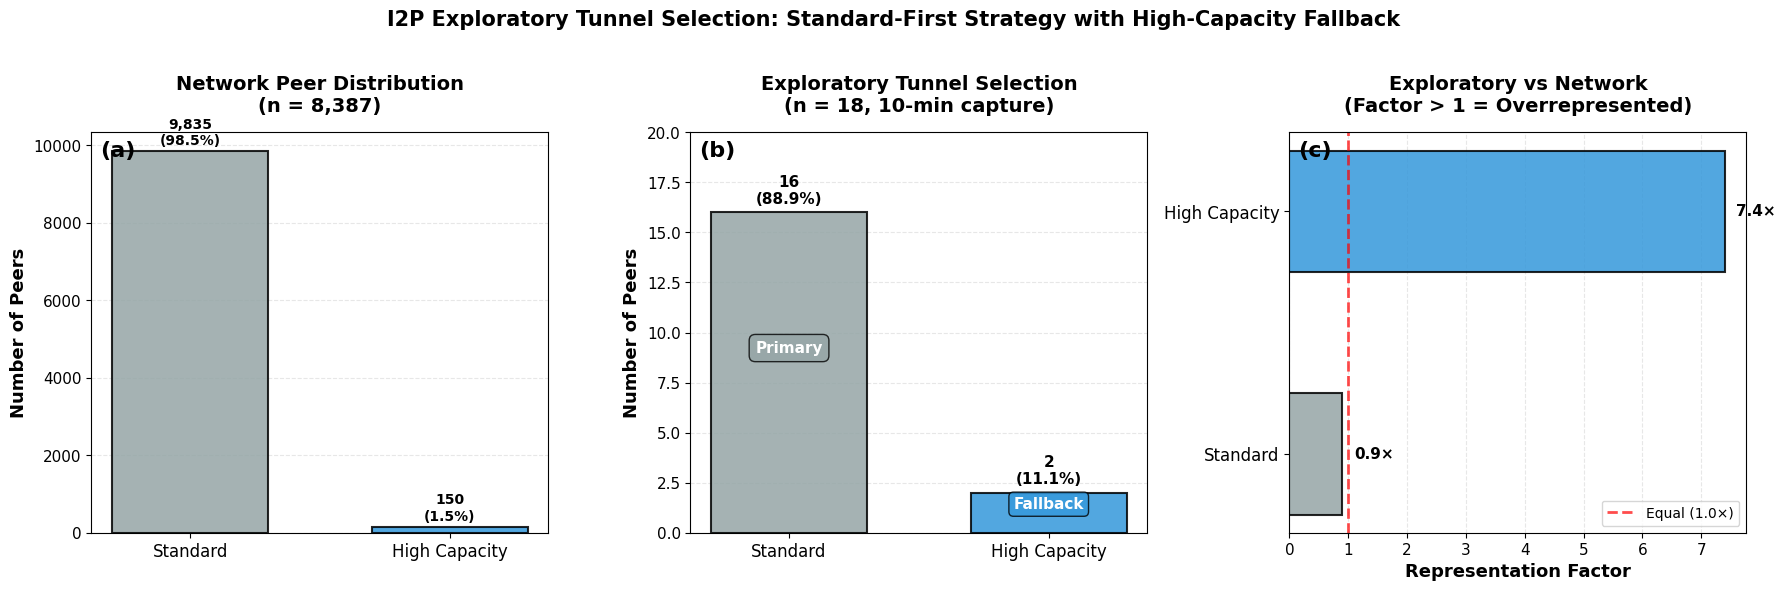

✅ Visualization complete


In [8]:
# Cell 7: Final Visualization for Experiment 4
# Purpose: Publication-ready 3-panel figure

import matplotlib.pyplot as plt
import numpy as np

print("Creating publication visualization...")

plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor('white')

COLORS = {'High Capacity': '#3498db', 'Standard': '#95a5a6'}

# ================================================================
# PANEL 1: Network Distribution
# ================================================================
ax1 = axes[0]

network_counts = peer_profiles['Tier'].value_counts()
tiers = ['Standard', 'High Capacity']
net_values = [network_counts.get(t, 0) for t in tiers]
colors1 = [COLORS[t] for t in tiers]

bars = ax1.bar(range(2), net_values, color=colors1, alpha=0.85,
               edgecolor='black', linewidth=1.5, width=0.6)

ax1.set_xticks(range(2))
ax1.set_xticklabels(tiers, fontsize=12)
ax1.set_ylabel('Number of Peers', fontsize=13, fontweight='bold')
ax1.set_title('Network Peer Distribution\n(n = 8,387)', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

for i, v in enumerate(net_values):
    pct = (v / sum(net_values)) * 100
    ax1.text(i, v + 100, f'{v:,}\n({pct:.1f}%)', ha='center', va='bottom',
             fontsize=10, fontweight='bold')

# ================================================================
# PANEL 2: Exploratory Tunnel Selection (10-min capture)
# ================================================================
ax2 = axes[1]

exp_counts = exploratory_final['Tier'].value_counts()
exp_values = [exp_counts.get(t, 0) for t in tiers]
colors2 = [COLORS[t] for t in tiers]

bars = ax2.bar(range(2), exp_values, color=colors2, alpha=0.85,
               edgecolor='black', linewidth=1.5, width=0.6)

ax2.set_xticks(range(2))
ax2.set_xticklabels(tiers, fontsize=12)
ax2.set_ylabel('Number of Peers', fontsize=13, fontweight='bold')
ax2.set_title('Exploratory Tunnel Selection\n(n = 18, 10-min capture)',
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)
ax2.set_ylim(0, 20)

for i, v in enumerate(exp_values):
    if v > 0:
        pct = (v / sum(exp_values)) * 100
        ax2.text(i, v + 0.3, f'{v}\n({pct:.1f}%)', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

# Add annotations
ax2.text(0, 9, 'Primary', ha='center', fontsize=11,
         fontweight='bold', color='white',
         bbox=dict(boxstyle='round,pad=0.4', facecolor=COLORS['Standard'], alpha=0.8))
ax2.text(1, 1.2, 'Fallback', ha='center', fontsize=11,
         fontweight='bold', color='white',
         bbox=dict(boxstyle='round,pad=0.3', facecolor=COLORS['High Capacity'], alpha=0.8))

# ================================================================
# PANEL 3: Representation Factor
# ================================================================
ax3 = axes[2]

network_pct = peer_profiles['Tier'].value_counts(normalize=True) * 100
exp_pct = exploratory_final['Tier'].value_counts(normalize=True) * 100

factors = []
for tier in tiers:
    net = network_pct.get(tier, 0.01)
    exp = exp_pct.get(tier, 0)
    factor = exp / net if net > 0 else 0
    factors.append(factor)

colors3 = [COLORS[t] for t in tiers]
bars = ax3.barh(range(2), factors, color=colors3, alpha=0.85,
                edgecolor='black', linewidth=1.5, height=0.5)

ax3.set_yticks(range(2))
ax3.set_yticklabels(tiers, fontsize=12)
ax3.set_xlabel('Representation Factor', fontsize=13, fontweight='bold')
ax3.set_title('Exploratory vs Network\n(Factor > 1 = Overrepresented)',
              fontsize=14, fontweight='bold', pad=15)
ax3.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Equal (1.0×)')
ax3.grid(axis='x', alpha=0.3, linestyle='--')
ax3.set_axisbelow(True)
ax3.legend(fontsize=10)

for i, v in enumerate(factors):
    ax3.text(v + 0.2, i, f'{v:.1f}×', va='center', fontsize=11, fontweight='bold')

# Panel labels
for i, ax in enumerate(axes):
    ax.text(0.02, 0.98, f'({chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top')

# Main title
fig.suptitle('I2P Exploratory Tunnel Selection: Standard-First Strategy with High-Capacity Fallback',
             fontsize=15, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('experiment4_final.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Saved: experiment4_final.png")
plt.show()

print("="*70)
print("✅ Visualization complete")
print("="*70)